# Time series prediction
## First trial with Linear Regression
In this notebook we are going to explore the performance of a simple regressor on a time series
### Reading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(2018)

full_data =pd.read_csv('data/EightSeries.csv', parse_dates=['timestamp'], index_col='timestamp')
data = full_data.loc[full_data.index > '2011']


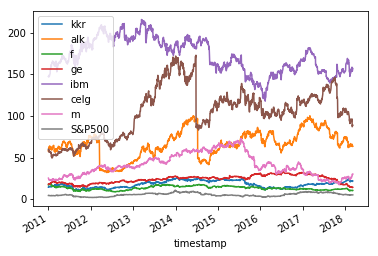

In [2]:
data.plot();

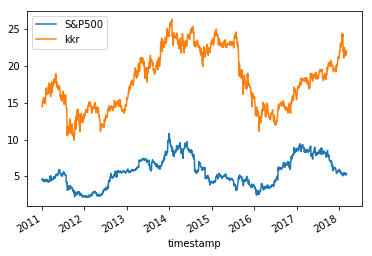

In [3]:
data[['S&P500', 'kkr']].plot();

### Scaling the data

In [4]:
reference_day = '2011-01-03'
data_div = data.div(data.loc[reference_day, :])
data_div.loc[reference_day, :]

kkr       1.0
alk       1.0
f         1.0
ge        1.0
ibm       1.0
celg      1.0
m         1.0
S&P500    1.0
Name: 2011-01-03 00:00:00, dtype: float64

In [5]:
data_sub = data_div.sub(data_div['S&P500'], axis='rows')
data_sub.loc[reference_day, :]

kkr       0.0
alk       0.0
f         0.0
ge        0.0
ibm       0.0
celg      0.0
m         0.0
S&P500    0.0
Name: 2011-01-03 00:00:00, dtype: float64

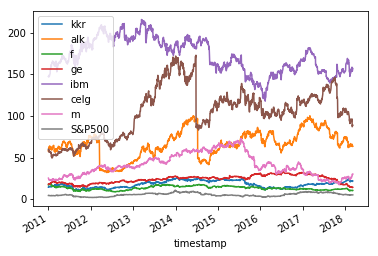

In [6]:
data.plot();

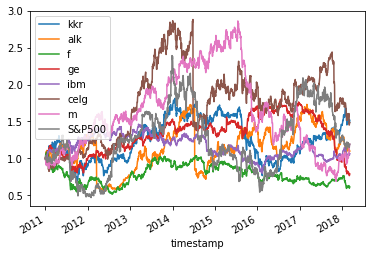

In [7]:
data_div.plot();

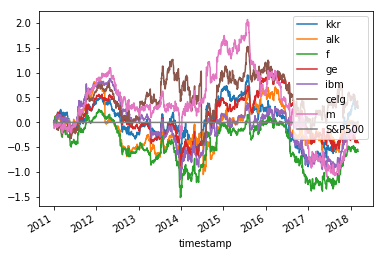

In [8]:
data_sub.plot();

### Preserving some data for eventual validation

In [9]:
test_data = data_sub[data_sub.index >= '2017-01-01']
train_data = data_sub[data_sub.index < '2017-01-01']     

### First one series: KKR

In [10]:
x_train = train_data.kkr   
x_test = test_data.kkr

We define a transformer that shapes the data in a X, y format

In [11]:
def sliding_windows(x, window, offset):
    """Transform x and create X as a rolling window and y as a target at offset
    """
    X = pd.concat( [ pd.Series(x[i:(i + window)] , name=x.index[i+window-1]).reset_index(drop=True) for i in range(0, x.shape[0] - window +  1)] , axis=1).T
    X = X.iloc[:-offset]
    y = x.loc[x.index >= X.index[offset]]
    return X , y    

We apply the transformer and obtain the data for regression

In [12]:
X_train, y_train = sliding_windows(x_train, window=220, offset=5)
X_test, y_test   = sliding_windows(x_test,  window=220, offset=5)

In [13]:
print('X shape: ', X_train.shape)
print('y shape: ', y_train.shape)
print('='*80)
print('X head:\n' + '='*80 + '\n', X_train.head(8))
print('='*80)
print('y head:\n' + '='*80 + '\n', y_train.head(8))

X shape:  (1286, 220)
y shape:  (1286,)
X head:
                  0         1         2         3         4         5    \
2011-11-14  0.000000  0.009855  0.019748  0.019303 -0.005280  0.025169   
2011-11-15  0.009855  0.019748  0.019303 -0.005280  0.025169  0.058873   
2011-11-16  0.019748  0.019303 -0.005280  0.025169  0.058873  0.071828   
2011-11-17  0.019303 -0.005280  0.025169  0.058873  0.071828  0.085962   
2011-11-18 -0.005280  0.025169  0.058873  0.071828  0.085962  0.094683   
2011-11-21  0.025169  0.058873  0.071828  0.085962  0.094683  0.116018   
2011-11-22  0.058873  0.071828  0.085962  0.094683  0.116018  0.102722   
2011-11-23  0.071828  0.085962  0.094683  0.116018  0.102722  0.090456   

                 6         7         8         9      ...          210  \
2011-11-14  0.058873  0.071828  0.085962  0.094683    ...     0.339618   
2011-11-15  0.071828  0.085962  0.094683  0.116018    ...     0.339654   
2011-11-16  0.085962  0.094683  0.116018  0.102722    ...     

Fitting a sklearn regressor

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

lm = LinearRegression()
pipe = Pipeline(steps=[('model', lm)])

param_grid={'model':[lm]}
gs = GridSearchCV(pipe, param_grid=param_grid, refit=True, cv=10)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
coef = np.absolute(gs.best_estimator_.named_steps['model'].coef_)
coef = pd.Series( (100 * coef/coef.sum()).round(1))
coef.sort_values(ascending=False).head(10)

219    12.4
28      1.3
160     1.2
67      1.2
127     1.2
107     1.0
162     1.0
190     1.0
45      1.0
194     1.0
dtype: float64

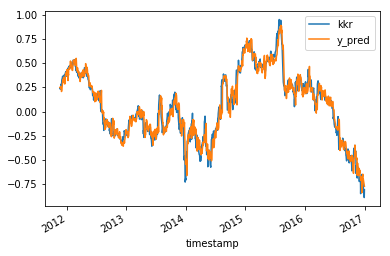

In [16]:
y_train_pred = pd.Series(lm.predict(X_train), name='y_pred', index=y_train.index)
both_y_train = pd.concat([y_train, y_train_pred], axis=1)
both_y_train.plot();

In [17]:
both_y_train.head()

,kkr,y_pred
timestamp,,
2011-11-21,0.235917,0.248558
2011-11-22,0.232862,0.245644
2011-11-23,0.245432,0.256247
2011-11-25,0.237111,0.242996
2011-11-28,0.282970,0.249727


In [18]:
gs.score(X_train,y_train)

0.94632557495849567

In [19]:
def mape(y_pred,y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hold out data error

In [20]:
gs.score(X_test, y_test)

0.67267376413360824

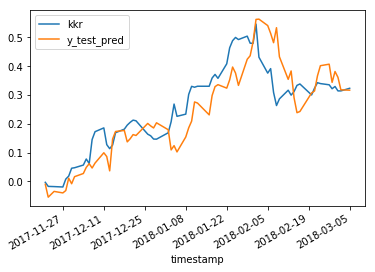

In [21]:
y_test_pred = pd.Series(lm.predict(X_test), name='y_test_pred', index=y_test.index)
both_y_test = pd.concat([y_test, y_test_pred], axis=1)
both_y_test.plot();

In [22]:
both_y_test.head()

,kkr,y_test_pred
timestamp,,
2017-11-21,-0.003288,-0.010112
2017-11-22,-0.017429,-0.054844
2017-11-24,-0.018119,-0.034817
2017-11-27,-0.019498,-0.040061
2017-11-28,0.007895,-0.031916
